# HR Analytics
### A predictive analytics project on HR data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

### 1. Introduction
The goal of this project is to study whether the resignation of employees can be predicted from certain variables. In addition, possible xplanations behind the resignations are discussed.
<br><br>
This project is based on the project "HR Analytics" on Kaggle: https://www.kaggle.com/jacksonchou/hr-analytics/report

### 1. Data

In [4]:
# Source for the dataset: https://www.kaggle.com/jacksonchou/hr-analytics/report
def datareader(path):
    """
    Reads the data file from the given path and returns a pandas dataframe.
    """
    dataframe = pd.read_csv("HR_comma_sep.csv")
    return dataframe

##### First look at the dataset
The dataset consists of 14999 data points (rows), each representing an employee. From each employee, the following information has been collected:

We see that the dataset consists of 14999 rows and 10 columns of data, with no missing values. Of those columns, 8/10 consist of numerical data, and two of categorical data. Let's take a closer look at the column data.

In [5]:
path = "HR_comma_sep.csv"
df = datareader(path)
print(f"The dataset has {df.shape[0]} rows, and {df.shape[1]} columns. Therefore, there are totally {df.shape[0]*df.shape[1]} possible values. Out of those possible values, {df.isnull().sum().sum()} were missing. \n")
print(df.dtypes)
print(df.describe(), "\n")
df.head(3)

The dataset has 14999 rows, and 10 columns. Therefore, there are totally 149990 possible values. Out of those possible values, 0 were missing. 

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object
       satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max            

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium


The variable "left" is a binary variable, describing whether the employee is has or has not the firm. It is also the property we aim to predict in this project. <br><br>

Some notes on the other variables (including some guessing):
* satisfaction_level: Measures job satisfaction, a value between 0 and 1
* last_evaluation: Presumably a grade given by the manager, takes a value between 0 and 1
* number_project: Presumably, the number of projects within the given timeframe.
* average_montly_hours: number of hours worked per month
* time_spend_company: Presumably, the number of years spent in the company
* Work accident: Number of work related accidents, or a binary variable.
* promotion_last_5years: A binary variable, telling whether the employee was promoted during the last 5 years.
* sales: A categorical variable on the section, e.g. sales, hr, technical, etc.
* salary: A categorical variable on the wage

The last two variables, not being numerical, but being categorical, can be replaced with numerical data:

In [6]:
df['sales'] = label_encoder.fit_transform(df['sales'])
df['salary'] = label_encoder.fit_transform(df['salary'])

In [7]:
df.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,7,1
1,0.80,0.86,5,262,6,0,1,0,7,2
2,0.11,0.88,7,272,4,0,1,0,7,2
3,0.72,0.87,5,223,5,0,1,0,7,1
4,0.37,0.52,2,159,3,0,1,0,7,1


### 2. Visualization
Let's first calculate a correlation matrix for the variables:

Text(0.5, 1.0, 'Correlation Heatmap')

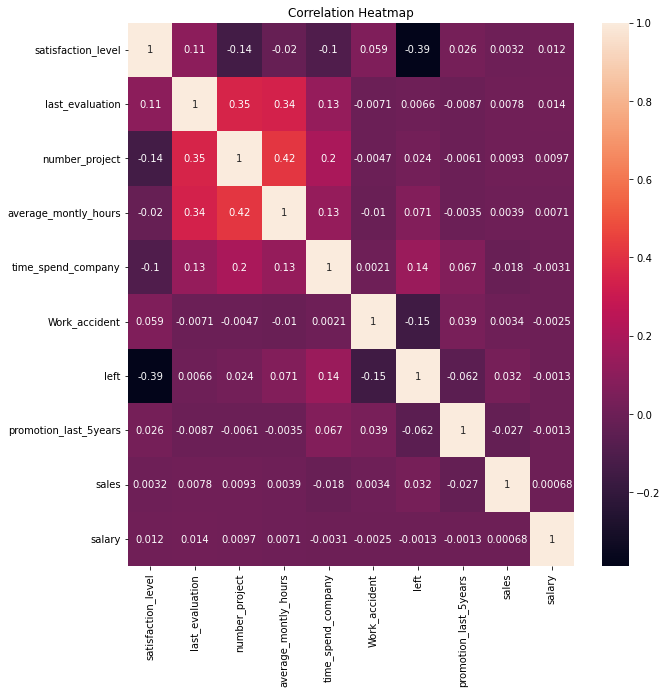

In [8]:
corr_matrix = df.corr() # Create the correlation matrix
fig, ax = plt.subplots(figsize=(10,10))  
sn.heatmap(corr_matrix, annot = True)
plt.title("Correlation Heatmap")

We see that there seems to be some negative correlation between leaving the workplace and job satisfaction ($-0.39$). Also, time spend in the company is mildly positive correlated with with leaving the workplace ($0.14$). Also, the work accident rate is smewhat negatively correlated with leaving ($-0.15$).

### 3. The Model
#### Model description
Next, let's create a model to predict whether the employee will be leaving his/her job or not. Based on the heatmap, we will use all the variables with correlation of larger than (smaller than) $0.1$ ($-0.1$) with the variable "left". We will use logistic regression as our model. Logistic rergession is used in problems where the explained variable is categorical, like in this case. <br> <br>

The model describes the probability: <br>$Pr(Y = y | satisfaction, accidents, time_spent)$ where $y \in \{0, 1\}$.
<br>

The model is of form:<br> $log(\dfrac{p}{(1-p)}) = \beta_0 + \beta_{satisfaction} + \beta_{accidents} + \beta_{timespent}$

#### Creating the trainng and the testing sets
Next, the data is split into two parts, the training set to train the logistic regression model, and the test set to check the model performance. We will use a 80/20 ratio for training/testing data set.

In [9]:
# First, let's create variables for explained and explaining variables
df = df.sample(frac=1).reset_index(drop=True) #Shuffle the dataset
y = df['left'] # Explained variable
X = df[['satisfaction_level', 'time_spend_company', 'Work_accident']] # Explaining variables

# Next split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Training the model

In [10]:
log_model = LogisticRegression(solver='liblinear', random_state=0)
log_model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

### 4. Results
The confusion matrix is of following form:

<AxesSubplot:>

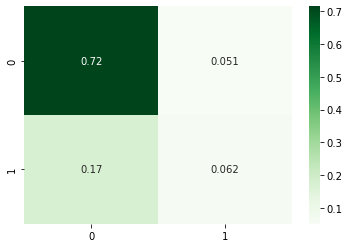

In [11]:
cf_matrix = confusion_matrix(y_test, log_model.predict(X_test))
sn.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, cmap='Greens')

This means that the model correctly predicted approximately 76% of the values in the test set. To get the exact prediction accuracy we can calculate it:

In [12]:
round(log_model.score(X_test, y_test), 3)

0.778

### 5. Only one explaining variable

Let's redo the same analysis, but only with one explaining variable, satisfaction level:

In [13]:
df = df.sample(frac=1).reset_index(drop=True) #Shuffle the dataset
y = df['left'] # Explained variable
X = df[['satisfaction_level']] # Explaining variables

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_model = LogisticRegression(solver='liblinear', random_state=0)
log_model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

<AxesSubplot:>

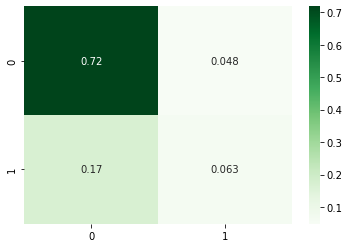

In [14]:
cf_matrix = confusion_matrix(y_test, log_model.predict(X_test))
sn.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, cmap='Greens')

In [15]:
round(log_model.score(X_test, y_test), 3)

0.781

The prediction accuracy was (interestingly) almost the same.